# Оценка потенциала территории

## Код

In [2]:
from enum import Enum

class Profile(Enum):
  RESIDENTIAL_INDIVIDUAL = 'Жилая застройка - ИЖС'
  RESIDENTIAL_LOWRISE = 'Жилая застройка - Малоэтажная'
  RESIDENTIAL_MIDRISE = 'Жилая застройка - Среднеэтажная'
  RESIDENTIAL_MULTISTOREY = 'Жилая застройка - Многоэтажная'
  BUSINESS = 'Общественно-деловая'
  RECREATION = 'Рекреационная'
  SPECIAL = 'Специального назначения'
  INDUSTRIAL = 'Промышленная'
  AGRICULTURE = 'Сельско-хозяйственная'
  TRANSPORT = 'Транспортная инженерная'

In [3]:
PROFILES = {
  Profile.RESIDENTIAL_INDIVIDUAL: {
      "criteria": {"population": 1, "transport": 2, "ecology": 4, "social": 4, "engineering": 3},
      "weights": {"population": 0, "transport": 0, "ecology": 1, "social": 1, "engineering": 0}
  },
  Profile.RESIDENTIAL_LOWRISE: {
      "criteria": {"population": 3, "transport": 3, "ecology": 4, "social": 3, "engineering": 4},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 1, "engineering": 1}
  },
  Profile.RESIDENTIAL_MIDRISE: {
      "criteria": {"population": 4, "transport": 4, "ecology": 4, "social": 3, "engineering": 5},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 1, "engineering": 1}
  },
  Profile.RESIDENTIAL_MULTISTOREY: {
      "criteria": {"population": 5, "transport": 5, "ecology": 4, "social": 3, "engineering": 5},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 1, "engineering": 1}
  },
  Profile.BUSINESS: {
      "criteria": {"population": 4, "transport": 5, "ecology": 4, "social": 2, "engineering": 4},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 0, "engineering": 1}
  },
  Profile.RECREATION: {
      "criteria": {"population": 0, "transport": 0, "ecology": 4, "social": 0, "engineering": 0},
      "weights": {"population": 0, "transport": 0, "ecology": 0, "social": 0, "engineering": 0}
  },
  Profile.SPECIAL: {
      "criteria": {"population": 0, "transport": 3, "ecology": 1, "social": 0, "engineering": 2},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 0, "engineering": 1}
  },
  Profile.INDUSTRIAL: {
      "criteria": {"population": 3, "transport": 4, "ecology": 0, "social": 2, "engineering": 4},
      "weights": {"population": 1, "transport": 1, "ecology": 0, "social": 0, "engineering": 1}
  },
  Profile.AGRICULTURE: {
      "criteria": {"population": 3, "transport": 4, "ecology": 4, "social": 2, "engineering": 3},
      "weights": {"population": 1, "transport": 1, "ecology": 1, "social": 0, "engineering": 1}
  },
  Profile.TRANSPORT: {
      "criteria": {"population": 2, "transport": 2, "ecology": 0, "social": 1, "engineering": 2},
      "weights": {"population": 0, "transport": 0, "ecology": 0, "social": 0, "engineering": 0}
  }
}

In [4]:
def _is_criterion_satisfied(profile_value, criterion_value):
    if isinstance(profile_value, tuple):
        return profile_value[0] <= criterion_value <= profile_value[1]
    return criterion_value >= profile_value

def _calculate_exceedance(profile_value, criterion_value):
    if isinstance(profile_value, tuple):
        if profile_value[0] <= criterion_value <= profile_value[1]:
            return criterion_value - profile_value[0]
        return 0
    return max(0, criterion_value - profile_value)

def calculate_potential(population, transport, ecology, social, engineering):
    
    criteria_values = {
        "population": population, 
        "transport": transport, 
        "ecology": ecology, 
        "social": social, 
        "engineering": engineering
    }

    potential_scores = {}
    for profile, data in PROFILES.items():
        criteria = data["criteria"]
        weights = data["weights"]
        potential = sum(
            _is_criterion_satisfied(criteria[criterion], value)
            for criterion, value in criteria_values.items()
        )
        weighted_score = sum(
            _calculate_exceedance(criteria.get(criterion, -1), value) * weights[criterion]
            for criterion, value in criteria_values.items()
        )
        potential_scores[profile.name] = {
            'potential': potential,
            'weighted_score': weighted_score
        }

    # ranked_profiles = sorted(potential_scores.items(), key=lambda x: (x[0] != "Рекреационная", x[1]['potential'], x[1]['weighted_score']), reverse=True)
    # ranked_profiles = [item for item in ranked_profiles if item[1]['potential'] > 0] + [item for item in ranked_profiles if item[1]['potential'] == 0]

    return potential_scores

## Оценка

In [5]:
import geopandas as gpd

population = gpd.read_file('grid_population_score.geojson').to_crs(4326).rename(columns={'score': 'population'})[['geometry', 'population']]
population.head()

,geometry,population
0,"POLYGON ((29.65352 60.75606, 29.69198 60.73276...",2.0
1,"POLYGON ((34.21298 59.70612, 34.24864 59.68080...",1.0
2,"POLYGON ((30.54114 59.98839, 30.57846 59.96455...",5.0
3,"POLYGON ((34.68571 60.95192, 34.72244 60.92676...",1.0
4,"POLYGON ((34.50920 59.59026, 34.54462 59.56480...",2.0


In [6]:
transport = gpd.read_parquet('hexagons_criteria.parquet')
transport = transport[['geometry', 'overall_assessment']].rename(columns={'overall_assessment':'transport'}).to_crs(4326)
transport['transport'] = transport['transport'].apply(lambda t : round(t,1))
transport.head()

,geometry,transport
0,"POLYGON ((29.65352 60.75606, 29.69198 60.73276...",0.8
1,"POLYGON ((34.21298 59.70612, 34.24864 59.68080...",0.2
2,"POLYGON ((30.54114 59.98839, 30.57846 59.96455...",4.5
3,"POLYGON ((34.68571 60.95192, 34.72244 60.92676...",1.4
4,"POLYGON ((34.50920 59.59026, 34.54462 59.56480...",1.2


In [7]:
import geopandas as gpd

ecology = gpd.read_file('grid_ecoframe.geojson').to_crs(4326).rename(columns={'relative mark':'ecology'})[['geometry', 'ecology']]
ecology.head()

,geometry,ecology
0,"POLYGON ((29.65352 60.75606, 29.69198 60.73276...",4.0
1,"POLYGON ((34.21298 59.70612, 34.24864 59.68080...",5.0
2,"POLYGON ((30.54114 59.98839, 30.57846 59.96455...",3.0
3,"POLYGON ((34.68571 60.95192, 34.72244 60.92676...",5.0
4,"POLYGON ((34.50920 59.59026, 34.54462 59.56480...",5.0


In [8]:
social = gpd.read_file('grid_social.geojson').to_crs(4326)
social.head()

,social,geometry
0,0.95,"POLYGON ((29.65352 60.75606, 29.69198 60.73276..."
1,0.20,"POLYGON ((34.21298 59.70612, 34.24864 59.68080..."
2,1.75,"POLYGON ((30.54114 59.98839, 30.57846 59.96455..."
3,0.45,"POLYGON ((34.68571 60.95192, 34.72244 60.92676..."
4,0.40,"POLYGON ((34.50920 59.59026, 34.54462 59.56480..."


In [9]:
gdf = population.copy()
gdf['transport'] = transport['transport']
gdf['ecology'] = ecology['ecology']
gdf['social'] = social['social']
gdf['engineering'] = 0

In [10]:
import pandas as pd

gdf['potential'] = gdf.apply(lambda s : {profile:res['potential'] for profile, res in calculate_potential(s.population, s.transport, s.ecology,s.social,s.engineering).items()}, axis=1)
potential_gdf = pd.merge(gdf, gdf.potential.apply(pd.Series).rename(columns=lambda c : f'Потенциал: {Profile[c].value}'), left_index=True, right_index=True).drop(columns=['potential'])

In [11]:
potential_gdf.to_file('potential.geojson')

In [12]:
potential_gdf.rename(columns={
  'population': 'Показатель: Население',
  'population': 'Показатель: Транспорт',
  'population': 'Показатель: Экология',
  'population': 'Показатель: Социальная обеспеченность',
  'population': 'Показатель: Инженерная инфраструктура'
})

,geometry,Показатель: Инженерная инфраструктура,transport,ecology,social,engineering,Потенциал: Жилая застройка - ИЖС,Потенциал: Жилая застройка - Малоэтажная,Потенциал: Жилая застройка - Среднеэтажная,Потенциал: Жилая застройка - Многоэтажная,Потенциал: Общественно-деловая,Потенциал: Рекреационная,Потенциал: Специального назначения,Потенциал: Промышленная,Потенциал: Сельско-хозяйственная,Потенциал: Транспортная инженерная
0,"POLYGON ((29.65352 60.75606, 29.69198 60.73276...",2.0,0.8,4.0,0.950,0,2,1,1,1,1,5,3,1,1,2
1,"POLYGON ((34.21298 59.70612, 34.24864 59.68080...",1.0,0.2,5.0,0.200,0,2,1,1,1,1,5,3,1,1,1
2,"POLYGON ((30.54114 59.98839, 30.57846 59.96455...",5.0,4.5,3.0,1.750,0,2,2,2,1,1,4,4,3,2,4
3,"POLYGON ((34.68571 60.95192, 34.72244 60.92676...",1.0,1.4,5.0,0.450,0,2,1,1,1,1,5,3,1,1,1
4,"POLYGON ((34.50920 59.59026, 34.54462 59.56480...",2.0,1.2,5.0,0.400,0,2,1,1,1,1,5,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,"POLYGON ((28.90861 60.56897, 28.94710 60.54592...",3.0,2.0,4.0,0.850,0,3,2,1,1,1,5,3,2,2,3
2144,"POLYGON ((32.84355 59.76933, 32.87981 59.74454...",1.0,2.5,4.0,0.775,0,3,1,1,1,1,5,3,1,1,2
2145,"POLYGON ((32.53064 59.24881, 32.56650 59.22401...",2.0,0.7,4.0,0.650,0,2,1,1,1,1,5,3,1,1,2
2146,"POLYGON ((30.05365 60.38205, 30.09156 60.35850...",3.0,3.4,4.0,1.875,0,3,3,1,1,1,5,4,2,2,4


In [13]:
potential_gdf

,geometry,population,transport,ecology,social,engineering,Потенциал: Жилая застройка - ИЖС,Потенциал: Жилая застройка - Малоэтажная,Потенциал: Жилая застройка - Среднеэтажная,Потенциал: Жилая застройка - Многоэтажная,Потенциал: Общественно-деловая,Потенциал: Рекреационная,Потенциал: Специального назначения,Потенциал: Промышленная,Потенциал: Сельско-хозяйственная,Потенциал: Транспортная инженерная
0,"POLYGON ((29.65352 60.75606, 29.69198 60.73276...",2.0,0.8,4.0,0.950,0,2,1,1,1,1,5,3,1,1,2
1,"POLYGON ((34.21298 59.70612, 34.24864 59.68080...",1.0,0.2,5.0,0.200,0,2,1,1,1,1,5,3,1,1,1
2,"POLYGON ((30.54114 59.98839, 30.57846 59.96455...",5.0,4.5,3.0,1.750,0,2,2,2,1,1,4,4,3,2,4
3,"POLYGON ((34.68571 60.95192, 34.72244 60.92676...",1.0,1.4,5.0,0.450,0,2,1,1,1,1,5,3,1,1,1
4,"POLYGON ((34.50920 59.59026, 34.54462 59.56480...",2.0,1.2,5.0,0.400,0,2,1,1,1,1,5,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,"POLYGON ((28.90861 60.56897, 28.94710 60.54592...",3.0,2.0,4.0,0.850,0,3,2,1,1,1,5,3,2,2,3
2144,"POLYGON ((32.84355 59.76933, 32.87981 59.74454...",1.0,2.5,4.0,0.775,0,3,1,1,1,1,5,3,1,1,2
2145,"POLYGON ((32.53064 59.24881, 32.56650 59.22401...",2.0,0.7,4.0,0.650,0,2,1,1,1,1,5,3,1,1,2
2146,"POLYGON ((30.05365 60.38205, 30.09156 60.35850...",3.0,3.4,4.0,1.875,0,3,3,1,1,1,5,4,2,2,4


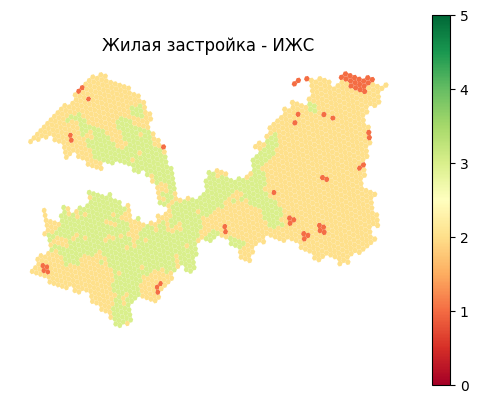

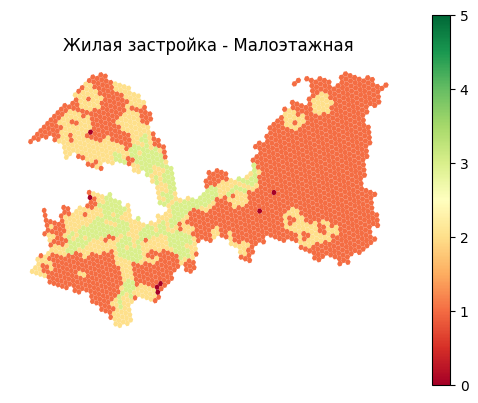

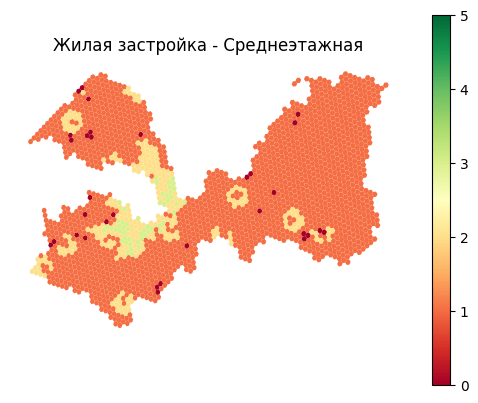

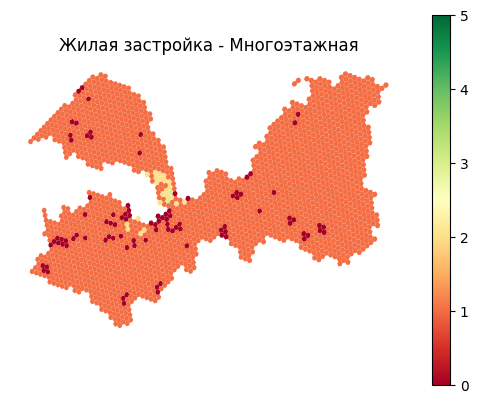

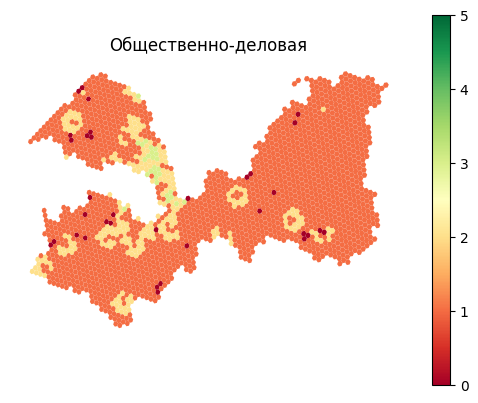

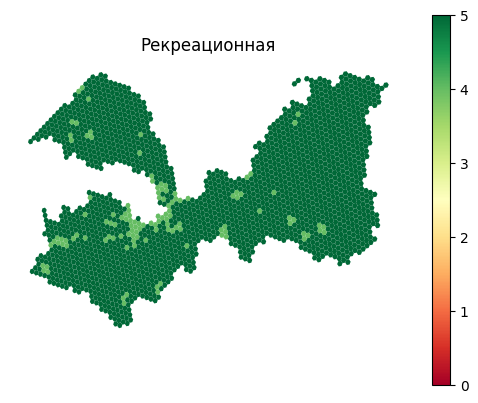

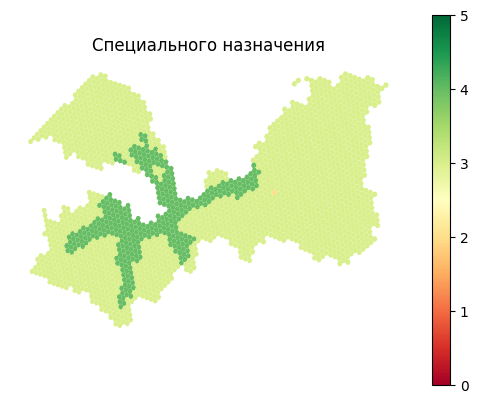

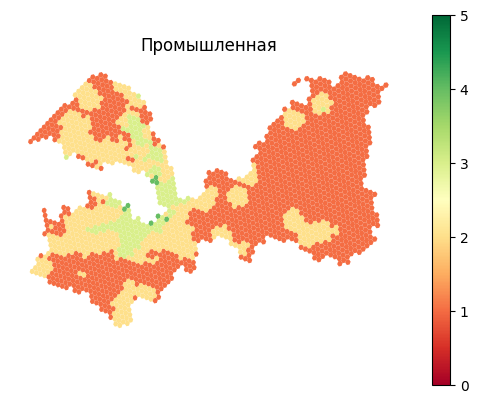

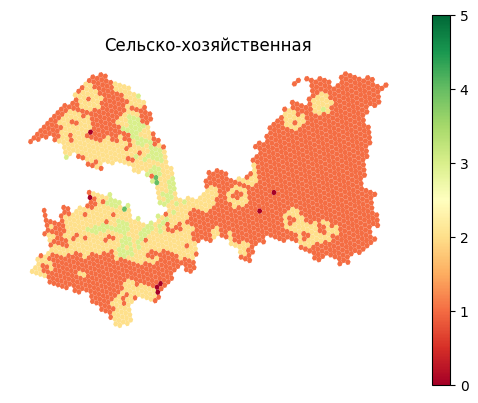

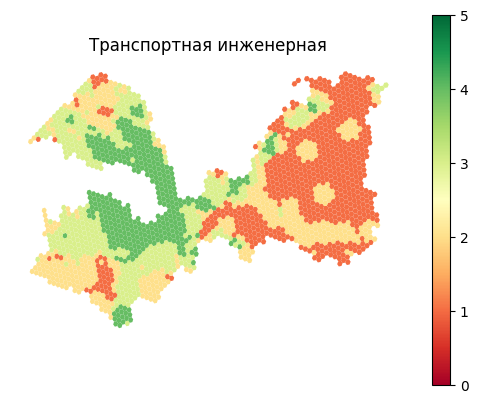

In [14]:
for profile in list(Profile):
  ax = potential_gdf.plot(column=f'Потенциал: {profile.value}', cmap='RdYlGn', vmax=5, vmin=0, legend=True)
  ax.set_axis_off()
  ax.set_title(profile.value)